# TF-SLIM 활용하기

In [5]:
import gzip
import os
from scipy import ndimage
from six.moves import urllib
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
print("PACKAGE LOADED")

PACKAGE LOADED


### Handling MNIST
- Data augmentation

In [3]:
# 1번째 방법 AUGMENT TRAINING DATA
# 아예 늘려놓고 training
def expend_training_data(images, labels):
    expanded_images = []
    expanded_labels = []
    j = 0 # counter
    for x, y in zip(images, labels):
        j = j+1
        # APPEND ORIGINAL DATA
        expanded_images.append(x)
        expanded_labels.append(y)
        # ASSUME MEDIAN COLOR TO BE BACKGROUND COLOR
        bg_value = np.median(x) # this is regarded as background's value        
        image = np.reshape(x, (-1, 28))

        for i in range(4):
            # ROTATE IMAGE
            angle = np.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)
            # SHIFT IAMGE
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img,shift, cval=bg_value)
            # ADD TO THE LIST
            expanded_images.append(np.reshape(new_img_, 784))
            expanded_labels.append(y)
    expanded_train_total_data = np.concatenate((expanded_images, expanded_labels), axis=1)
    np.random.shuffle(expanded_train_total_data)
    return expanded_train_total_data

In [4]:
# 2번째 방법
# CPU단에서 batch돌릴 때마다 augmentation 
def augment_img(xs):
    out  = np.copy(xs)
    xs_r = np.reshape(xs, [-1, 28, 28])
    for i in range(xs_r.shape[0]):
        xs_img = xs_r[i, :, :]
        bg_value = 0
        # ROTATE
        angle = np.random.randint(-15, 15, 1).astype(float)
        xs_img = ndimage.rotate(xs_img, angle, reshape=False, cval=bg_value)
        # ZOOM
        rg = 0.1
        zoom_factor = np.random.uniform(1., 1.+rg)
        h, w = xs_img.shape[:2]
        zh   = int(np.round(zoom_factor * h))
        zw   = int(np.round(zoom_factor * w))
        top  = (zh - h) // 2
        left = (zw - w) // 2
        zoom_tuple = (zoom_factor,) * 2 + (1,) * (xs_img.ndim - 2)
        temp = ndimage.zoom(xs_img[top:top+zh, left:left+zw], zoom_tuple)
        trim_top  = ((temp.shape[0] - h) // 2)
        trim_left = ((temp.shape[1] - w) // 2)
        xs_img = temp[trim_top:trim_top+h, trim_left:trim_left+w]
        # SHIFT
        shift = np.random.randint(-3, 3, 2)
        xs_img = ndimage.shift(xs_img, shift, cval=bg_value)
        # RESHAPE
        xs_v = np.reshape(xs_img, [1, -1])
        out[i, :] = xs_v
    return out

### INPUT Setting

In [7]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
valimg     = mnist.validation.images
vallabel   = mnist.validation.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


## Define Model
### CNN Model with TF-SLIM
- Batch normalization
- Dropout

In [37]:
n_input = 784
n_classes = 10

x = tf.placeholder(dtype='float', shape=[None, n_input])
y = tf.placeholder(dtype='float', shape=[None, n_classes])
is_training = tf.placeholder(tf.bool)

def CNN(inputs, _is_training=True):
    x = tf.reshape(inputs, shape=[-1,28,28,1])
    batch_norm_params = {'is_training': _is_training, 'decay': 0.9, 'updates_collections': None}
    net = slim.conv2d(x,num_outputs=32, kernel_size=[5,5], padding='SAME',
                      activation_fn = tf.nn.relu,
                      weights_initializer = tf.truncated_normal_initializer(stddev=0.01),
                      normalizer_params = batch_norm_params,
                      scope = 'conv1'
                     )
    net = slim.max_pool2d(net, kernel_size=[2,2], scope='pool1')
    net = slim.conv2d(net, num_outputs=64, kernel_size=[5,5], scope='conv2')
    net = slim.max_pool2d(net, kernel_size=[2,2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, num_outputs=1024,
                               activation_fn = tf.nn.relu,
                               weights_initializer = tf.truncated_normal_initializer(stddev=0.01),
                               normalizer_fn = slim.batch_norm,
                               normalizer_params = batch_norm_params,
                               scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=_is_training, scope='dropout4')
    out = slim.fully_connected(net, num_outputs=10, activation_fn=None, normalizer_fn=None, scope='fco')
    return out
print("Network Ready!!!")

Network Ready!!!


In [35]:
tf.reset_default_graph()

### Define Graph

In [38]:
# Prediction
pred = CNN(x, _is_training=is_training)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

# Initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print("Function Ready...!!")

Function Ready...!!


In [39]:
print ("=================== TRAINABLE VARIABLES ===================")
t_weights = tf.trainable_variables()
var_names_list = [v.name for v in tf.trainable_variables()] 
for i in range(len(t_weights)):
    wval = sess.run(t_weights[i])
    print ("[%d/%d] [%s] / SAHPE IS %s"  
           % (i, len(t_weights), var_names_list[i], wval.shape,))

=================== TRAINABLE VARIABLES ===================
[0/8] [conv1/weights:0] / SAHPE IS (5, 5, 1, 32)
[1/8] [conv1/biases:0] / SAHPE IS (32,)
[2/8] [conv2/weights:0] / SAHPE IS (5, 5, 32, 64)
[3/8] [conv2/biases:0] / SAHPE IS (64,)
[4/8] [fc4/weights:0] / SAHPE IS (3136, 1024)
[5/8] [fc4/BatchNorm/beta:0] / SAHPE IS (1024,)
[6/8] [fco/weights:0] / SAHPE IS (1024, 10)
[7/8] [fco/biases:0] / SAHPE IS (10,)


### Saver

In [40]:
savedir = "nets/cnn_mnist_modern/"
saver = tf.train.Saver(max_to_keep=100)
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("SAVER READY")

SAVER READY


### Test Augmentation

C:\ProgramData\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


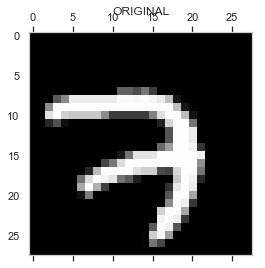

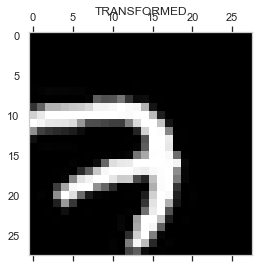

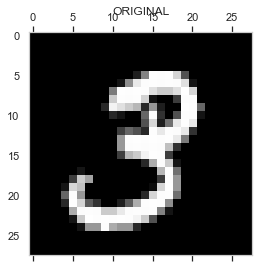

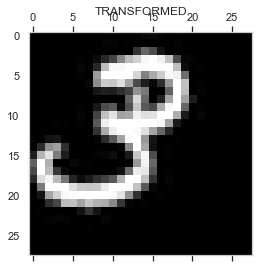

In [41]:
naug = 2
batch_xs = trainimg[:naug, :]
xs2 = augment_img(batch_xs)
for i in range(naug):
    x1 = batch_xs[i, :].reshape([28, 28])
    x2 = xs2[i, :].reshape([28, 28])
    plt.matshow(x1, vmin=0, vmax=1, cmap=plt.cm.gray)
    plt.title("ORIGINAL")
    plt.grid(False)
    plt.show()
    plt.matshow(x2, vmin=0, vmax=1, cmap=plt.cm.gray)
    plt.title("TRANSFORMED")
    plt.grid(False)
    plt.show()

### Run

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# PARAMETERS
training_epochs = 100
batch_size      = 50
display_step    = 4
val_acc         = 0
val_acc_max     = 0
# OPTIMIZE
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # ITERATION
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # AUGMENT DATA
        batch_xs = augment_img(batch_xs)
        feeds = {x: batch_xs, y: batch_ys, is_training: True}
        sess.run(optimizer, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # DISPLAY
    if (epoch+1) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        randidx = np.random.permutation(trainimg.shape[0])[:500]
        feeds = {x: trainimg[randidx], y: trainlabel[randidx], is_training: False}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.5f" % (train_acc))
        feeds = {x: valimg, y: vallabel, is_training: False}
        val_acc = sess.run(accr, feed_dict=feeds)
        print (" VALIDATION ACCURACY: %.5f" % (val_acc))    
    # SAVE
    if (epoch+1) % save_step == 0:
        savename = savedir + "net-" + str(epoch) + ".ckpt"
        saver.save(sess=sess, save_path=savename)
        print (" [%s] SAVED." % (savename))
    # MAXIMUM VALIDATION ACCURACY
    if val_acc > val_acc_max:
        val_acc_max = val_acc
        best_epoch = epoch
        print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print ("OPTIMIZATION FINISHED")